In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from utils import spectrum

In [2]:
#Retrieve raw data and prepare spectra
#This cell is the same as in "01_VisualInspection"

data=np.load('20200129_All_data_lists.npz',allow_pickle=True)

All_freqs,All_ints,All_unique_freqs,\
All_unique_ints,All_unique_inds,all_angles=\
(data["arr_0"],data["arr_1"],data["arr_2"],\
 data["arr_3"],data["arr_4"],data["arr_5"])

all_sorted_angles=np.sort(all_angles)
sorted_indices=np.argsort(all_angles)

All_sorted_freqs=All_freqs[sorted_indices]
All_sorted_ints=All_ints[sorted_indices]

#Filter and collect intensities and corresponding frequencies
filtered_ints=[]
filtered_freqs=[]
for sys_idx in range(len(All_ints)):

    #Intensities larger than 1/100 of the max intensity
    filt_inds=np.where(All_sorted_ints[sys_idx]>np.max(All_sorted_ints[sys_idx])/100)[0]
    
    filtered_ints.append(All_sorted_ints[sys_idx][filt_inds])
    filtered_freqs.append(All_sorted_freqs[sys_idx][filt_inds])
    

#Construct spectra using filtered intensities
#FWHM Width of the Lorentzian used for broadening
# in cm^-1
gamma=0.5

#Disregard freqs smaller than 1cm^{-1}
#grid density 0.25cm$^{-1}$
test_freqs,step=np.linspace(1.0,1750,endpoint=True,num=7000,retstep=True) 

All_spectra=np.zeros((len(test_freqs),len(All_freqs)))

for sys_idx in range(len(All_ints)):

    #spectrum function from utils.py
    All_spectra[:,sys_idx]=\
    spectrum(test_freqs,filtered_freqs[sys_idx],filtered_ints[sys_idx],gamma,step)

In [3]:
from sklearn.model_selection import train_test_split

# Prepare the training and test data sets 
# using teh train_test_split function
# from sklearn's model_selection module

# Focus on the strongest intensity features above 1625 cm^{-1}
gband_spec=np.transpose(All_spectra[np.where(test_freqs>=1625)[0],:])

#Split the total dataset into training and testing sets
# --> roughly 75% for training and 15% for testing
target_train, target_test,features_train, features_test =\
    train_test_split(all_sorted_angles,gband_spec,train_size=600, random_state=42)

print('Shapes of the train and test arrays, respectively.')
print(features_train.shape, features_test.shape)

Shapes of the train and test arrays, respectively.
(600, 501) (92, 501)


In [5]:
from sklearn.decomposition import PCA

# Perform principal component analysis
# Print the proportion of explained variance 
# that the first 5 principal components explain
# Compare the proportions for 
# the full spectra and for the G-band limited spectra.

pca1=PCA()

fullspectra=pca1.fit(np.transpose(All_spectra))

print('Full spectra')
print(fullspectra.explained_variance_ratio_[:5])

Full_featuresNew = pca1.transform(np.transpose(All_spectra))

pca2=PCA()

gbandspectra=pca2.fit(np.transpose(All_spectra[np.where(test_freqs>=1625)[0],:]))

print('G-band spectra')
print(gbandspectra.explained_variance_ratio_[:5])

G_featuresNew = pca2.transform(np.transpose(All_spectra[np.where(test_freqs>=1625)[0],:]))

print("--> G-band spectra contain ~all relevant information")

Full spectra
[0.36539994 0.16502898 0.06258397 0.05365762 0.04877908]
G-band spectra
[0.36546589 0.16508782 0.0626133  0.05368309 0.0487983 ]
--> G-band spectra contain ~all relevant information


In [6]:
# Get appropriate labels for the angles
# helpfer function defined in utils.py
from utils import def_angle_labels
sorted_angle_labels=def_angle_labels(all_sorted_angles,3)

num_labels=[]
for agl in sorted_angle_labels:
    if agl=='LE10':
        num_labels.append(0)
    elif agl=='G10LE20':
        num_labels.append(1)
    else:
        num_labels.append(2)

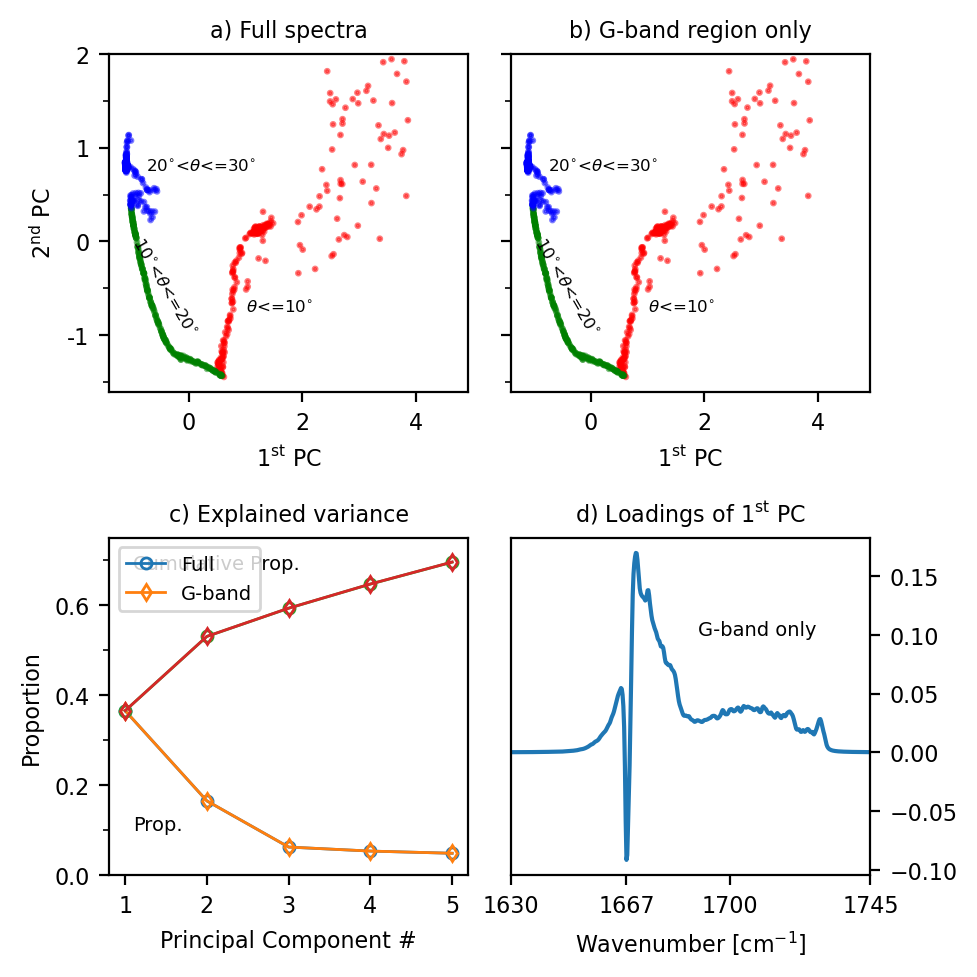

In [10]:
#Make a plot comparing PCA for full spectra and for G_band region only
from matplotlib.ticker import MultipleLocator,FormatStrFormatter


fig, ax = plt.subplots(2, 2,figsize=plt.figaspect(1.), dpi=200, facecolor='w', edgecolor='k')

def_fontsize=8

colors=['red','green','blue']

#Top row: Proportion of Explained variance and cumulative explained variance
for n,axm in enumerate(ax.flat):
    
#     axm.set_title(n)
    axm.tick_params(axis='both', which='both',labelsize=def_fontsize,right=False) 
    
    
    
    if n==0 or n==1:
        
        axm.set_ylim([-1.6,2.])
        axm.yaxis.set_major_locator(MultipleLocator(1))
        axm.yaxis.set_minor_locator(MultipleLocator(0.5))
        axm.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    
        l2 = np.array((-1., 0.))
        # Rotate angle
        angle = -60
        trans_angle = plt.gca().transData.transform_angles(np.array((angle,)),
                                                           l2.reshape((1, 2)))[0]
    
        axm.text(1.,-0.75,r'$\theta$<=10$^{\circ}$',fontsize=def_fontsize-2)
        axm.text(-1.,0.,r'10$^{\circ}$<$\theta$<=20$^{\circ}$',fontsize=def_fontsize-2,
                rotation=trans_angle, rotation_mode='anchor')
        axm.text(-0.75,0.75,r'20$^{\circ}$<$\theta$<=30$^{\circ}$',fontsize=def_fontsize-2)

    if n==2:    
        
        
        axm.set_ylim([0,0.75])
        axm.yaxis.set_major_locator(MultipleLocator(0.2))
        axm.yaxis.set_minor_locator(MultipleLocator(0.1))
        axm.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        axm.set_ylabel(r'Proportion',fontsize=def_fontsize)
        axm.set_title(r'c) Explained variance',fontsize=def_fontsize)        
    
        axm.text(1.1,0.1,'Prop.',fontsize=def_fontsize-1)
        
        axm.text(1.1,0.68,'Cumulative Prop.',fontsize=def_fontsize-1)
        
        axm.xaxis.set_major_locator(MultipleLocator(1))
        axm.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        
        axm.plot(range(1,1+len(fullspectra.explained_variance_ratio_[:5])),
                 fullspectra.explained_variance_ratio_[:5],'o-',
                 fillstyle='none',label='Full',markersize=4,linewidth=1.)
        
        axm.plot(range(1,1+len(gbandspectra.explained_variance_ratio_[:5])),
                 gbandspectra.explained_variance_ratio_[:5],'d-',
                 fillstyle='none',label='G-band',markersize=4,linewidth=1.)
        axm.legend(fontsize=7)
        
        axm.set_xlabel(r'Principal Component #',fontsize=def_fontsize)
        
        axm.xaxis.set_major_locator(MultipleLocator(1))
        axm.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        
        
        #Ths=
        axm.plot(range(1,1+len(fullspectra.explained_variance_ratio_[:5])),
                 np.cumsum(fullspectra.explained_variance_ratio_[:5]),'o-',
                 fillstyle='none',markersize=4#,label='Full'
                 ,linewidth=1.
                )
        
        axm.plot(range(1,1+len(gbandspectra.explained_variance_ratio_[:5])),
                 np.cumsum(gbandspectra.explained_variance_ratio_[:5]),'d-',
                 fillstyle='none',markersize=4#,label='G-band'
                 ,linewidth=1.
                )
        axm.legend(fontsize=7)
        
    elif n==0:
        axm.set_ylabel(r'2$^{\mathrm{nd}}$ PC',fontsize=def_fontsize)
        axm.set_xlabel(r'1$^{\mathrm{st}}$ PC',fontsize=def_fontsize)
        
        axm.scatter(Full_featuresNew[:,0],Full_featuresNew[:,1],alpha=0.5,s=2,
                    c=num_labels,cmap=matplotlib.colors.ListedColormap(colors)
                   )
        
        axm.set_title('a) Full spectra',fontsize=def_fontsize)
        
    elif n==1:
        
        axm.set_title('b) G-band region only',fontsize=def_fontsize)
        axm.set_xlabel(r'1$^{\mathrm{st}}$ PC',fontsize=def_fontsize)
        axm.set_yticklabels([]) 
        axm.scatter(G_featuresNew[:,0],G_featuresNew[:,1],alpha=0.5,s=2,
                    c=num_labels,cmap=matplotlib.colors.ListedColormap(colors))


    elif n==3:
        
        axm.set_xlim([1630.,1745])
        axm.xaxis.set_major_locator(MultipleLocator(50))        
        axm.yaxis.set_label_position("right")
        axm.yaxis.tick_right()
        axm.set_title(r'd) Loadings of 1$^{\mathrm{st}}$ PC',fontsize=def_fontsize)
        axm.set_xlabel(r'Wavenumber [cm$^{-1}$]',fontsize=def_fontsize)
        axm.plot(test_freqs[np.where(test_freqs>=1625)[0]],gbandspectra.components_[0]
                 ,linewidth=1.5)

        axm.text(1690,0.1,'G-band only',fontsize=def_fontsize-1)
        
        axm.set_xticks([1630., 1667., 1700., 1745.])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.show()